In [1]:
# Step 0. Import libraries, custom modules and logging
import kagglehub
# Data -----------------------------------------------------------------
import pandas as pd
import numpy as np
# Graphics -------------------------------------------------------------
import matplotlib.pyplot as plt
import seaborn as sns
# Machine learning -----------------------------------------------------
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import (mean_squared_error,
                             mean_absolute_error,
                             r2_score,
                             root_mean_squared_error)
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import (OneHotEncoder,
                                   MinMaxScaler,
                                  )



/home/codespace/.local/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# 1. Create dataframe 
path = kagglehub.dataset_download("shubhambathwal/flight-price-prediction")
df_raw = pd.read_csv('/home/codespace/.cache/kagglehub/datasets/shubhambathwal/flight-price-prediction/versions/2/Clean_Dataset.csv')

In [3]:
# 1.1 Read from source and get basic info
df_raw.info(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300153 entries, 0 to 300152
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Unnamed: 0        300153 non-null  int64  
 1   airline           300153 non-null  object 
 2   flight            300153 non-null  object 
 3   source_city       300153 non-null  object 
 4   departure_time    300153 non-null  object 
 5   stops             300153 non-null  object 
 6   arrival_time      300153 non-null  object 
 7   destination_city  300153 non-null  object 
 8   class             300153 non-null  object 
 9   duration          300153 non-null  float64
 10  days_left         300153 non-null  int64  
 11  price             300153 non-null  int64  
dtypes: float64(1), int64(3), object(8)
memory usage: 27.5+ MB


In [4]:
df_raw.sample(10, random_state=2024)

,Unnamed: 0,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price
188141,188141,Vistara,UK-838,Chennai,Night,one,Afternoon,Mumbai,Economy,17.92,7,11069
76293,76293,Air_India,AI-809,Mumbai,Morning,one,Evening,Hyderabad,Economy,9.33,42,4593
154012,154012,Indigo,6E-913,Hyderabad,Morning,one,Night,Delhi,Economy,11.00,15,9073
112678,112678,GO_FIRST,G8-790,Bangalore,Afternoon,one,Night,Hyderabad,Economy,8.17,27,4801
147683,147683,Vistara,UK-778,Kolkata,Afternoon,one,Afternoon,Hyderabad,Economy,21.25,46,5632
29584,29584,Indigo,6E-552,Delhi,Early_Morning,zero,Morning,Hyderabad,Economy,2.25,9,5955
118219,118219,Air_India,AI-9517,Bangalore,Evening,one,Early_Morning,Chennai,Economy,12.50,33,5221
101933,101933,Indigo,6E-841,Bangalore,Afternoon,one,Evening,Mumbai,Economy,5.17,45,4105
274910,274910,Vistara,UK-874,Hyderabad,Morning,one,Night,Delhi,Business,12.17,5,57990
126582,126582,Indigo,6E-7583,Kolkata,Afternoon,one,Night,Delhi,Economy,6.33,44,5198


In [5]:
 #Step 2. Prepare the dataset for analysis
df_interim = (
    df_raw
    .copy()
    .set_axis(
        df_raw.columns.str.replace(' ', '_') # reemplazar espacio por _
        .str.replace(r'\W','',regex=True) # reemplazar caracteres no alfabéticos por nada
        .str.lower() # el resultado lo pasamos a minúsculas
        .str.slice(0,40), axis=1, # slice sirve para cortar el texto a un máximo de 40 caracteres
    )
    .rename(columns={'price':'target'})
    .iloc[:,1:]
    .drop("flight", axis = 1)
    .astype({"airline": "category", "source_city": "category", "departure_time": "category", "stops": "category", "arrival_time": "category", "destination_city": "category", "class": "category"})


)
df_interim.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300153 entries, 0 to 300152
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype   
---  ------            --------------   -----   
 0   airline           300153 non-null  category
 1   source_city       300153 non-null  category
 2   departure_time    300153 non-null  category
 3   stops             300153 non-null  category
 4   arrival_time      300153 non-null  category
 5   destination_city  300153 non-null  category
 6   class             300153 non-null  category
 7   duration          300153 non-null  float64 
 8   days_left         300153 non-null  int64   
 9   target            300153 non-null  int64   
dtypes: category(7), float64(1), int64(2)
memory usage: 8.9 MB


In [6]:
# 2.2 Create the final dataset with the target in front, show result
df = (
    df_interim
    .copy()
    .reindex(
        columns=(
            ['target'] +
            [c for c in df_interim.columns.to_list() if c not in ['target']]
        )
    )
)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300153 entries, 0 to 300152
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype   
---  ------            --------------   -----   
 0   target            300153 non-null  int64   
 1   airline           300153 non-null  category
 2   source_city       300153 non-null  category
 3   departure_time    300153 non-null  category
 4   stops             300153 non-null  category
 5   arrival_time      300153 non-null  category
 6   destination_city  300153 non-null  category
 7   class             300153 non-null  category
 8   duration          300153 non-null  float64 
 9   days_left         300153 non-null  int64   
dtypes: category(7), float64(1), int64(2)
memory usage: 8.9 MB


In [7]:
# Step 3. Perform EDA
# 3.1 Split the dataset
df_train, df_test = train_test_split(df,
                                     random_state=2024,
                                     test_size=0.2)
df_train = df_train.reset_index(drop=True).sort_values(by='target')
df_train.info()


<class 'pandas.core.frame.DataFrame'>
Index: 240122 entries, 193521 to 143788
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype   
---  ------            --------------   -----   
 0   target            240122 non-null  int64   
 1   airline           240122 non-null  category
 2   source_city       240122 non-null  category
 3   departure_time    240122 non-null  category
 4   stops             240122 non-null  category
 5   arrival_time      240122 non-null  category
 6   destination_city  240122 non-null  category
 7   class             240122 non-null  category
 8   duration          240122 non-null  float64 
 9   days_left         240122 non-null  int64   
dtypes: category(7), float64(1), int64(2)
memory usage: 8.9 MB


In [8]:
display(df_train.describe(include='category').T)
display(df_train.describe().T)

,count,unique,top,freq
airline,240122,6,Vistara,102169
source_city,240122,6,Delhi,49094
departure_time,240122,6,Morning,57052
stops,240122,3,one,200783
arrival_time,240122,6,Night,73214
destination_city,240122,6,Mumbai,47253
class,240122,2,Economy,165367


,count,mean,std,min,25%,50%,75%,max
target,240122.0,20882.541475,22689.732214,1105.00,4783.00,7425.00,42521.00,123071.00
duration,240122.0,12.227363,7.189270,0.83,6.83,11.25,16.17,49.83
days_left,240122.0,26.001533,13.558442,1.00,15.00,26.00,38.00,49.00


In [9]:
inputs_cols=['airline',  'source_city', 'departure_time','stops', 'arrival_time',
            'destination_city', 'class', 'duration', 'days_left']
targets_col='target'

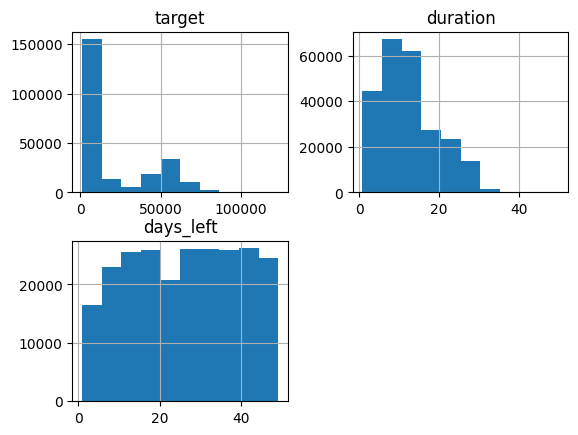

In [10]:
# Análisis univariado variables numéricas
df_train.hist()
plt.show()

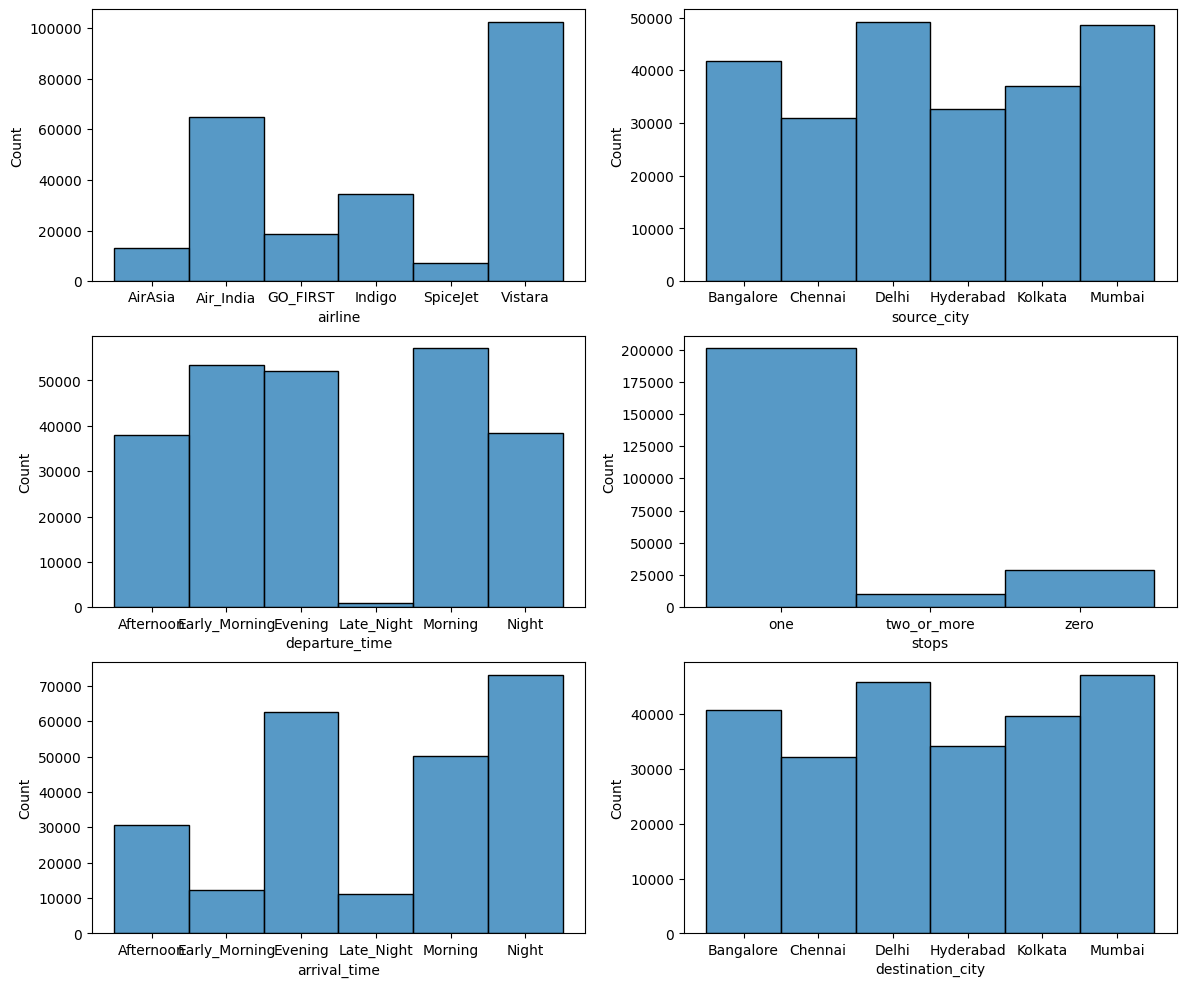

In [11]:
# Análisis univariado variables categóricas
fig, axis = plt.subplots(3, 2, figsize = (14, 12))
sns.histplot(ax = axis[0, 0], data = df_train, x = "airline")
sns.histplot(ax = axis[0, 1], data = df_train, x = "source_city")
sns.histplot(ax = axis[1, 0], data = df_train, x = "departure_time")
sns.histplot(ax = axis[1, 1], data = df_train, x = "stops")
sns.histplot(ax = axis[2, 0], data = df_train, x = "arrival_time")
sns.histplot(ax = axis[2, 1], data = df_train, x = "destination_city")
plt.show()

[Text(0.5, 0, ''), Text(0, 0.5, '')]

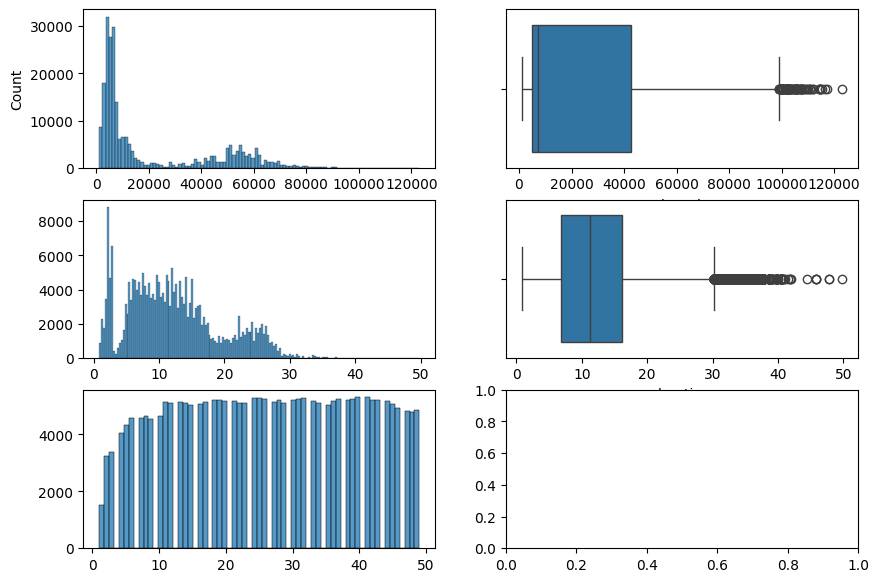

In [12]:
# Análisis variado variables numericas
fig, axis = plt.subplots(3, 2, figsize = (10, 7))
sns.histplot(ax = axis[0, 0], data = df_train, x= "target").set(xlabel = None)
sns.boxplot(ax = axis[0, 1], data = df_train, x = "target")
sns.histplot(ax = axis[1, 0], data = df_train, x = "duration").set(xlabel = None, ylabel = None)
sns.boxplot(ax = axis[1, 1], data = df_train, x = "duration")
sns.histplot(ax = axis[2, 0], data = df_train, x = "days_left").set(xlabel = None, ylabel = None)

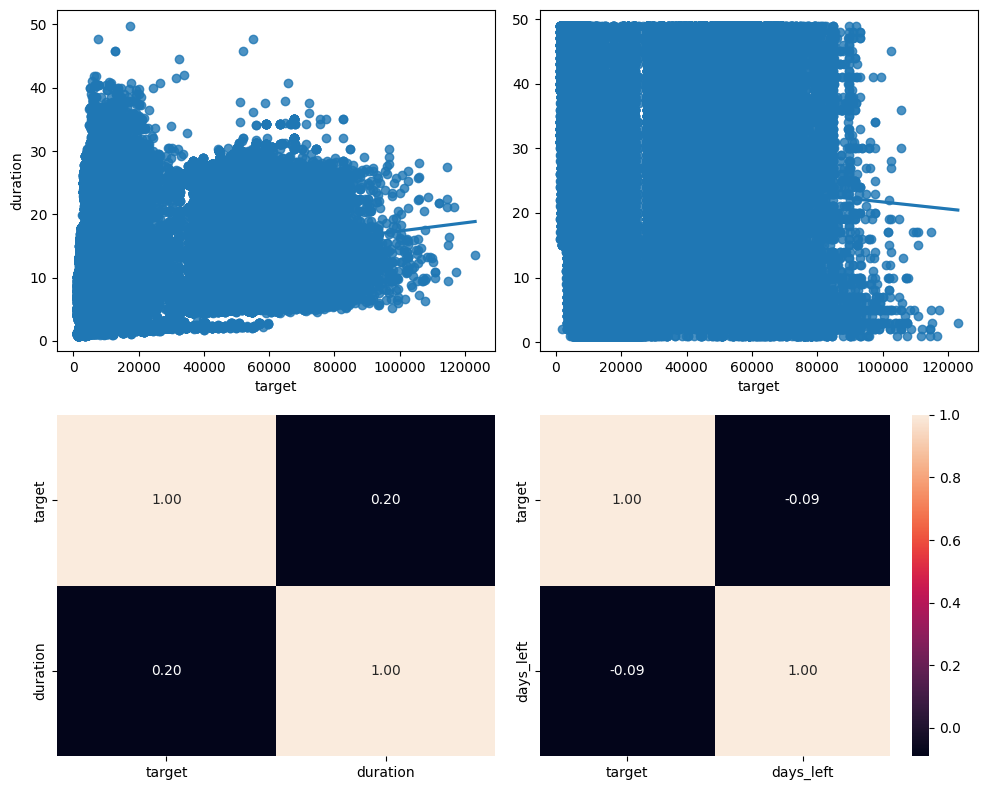

In [13]:
# Análisis bivariado variables categóricas
# Create a multiple scatter diagram
fig, axis = plt.subplots(2, 2, figsize=(10, 8))

# Gráficos de regresión y heatmaps
sns.regplot(ax=axis[0, 0], data=df_train, x="target", y="duration")
sns.heatmap(df_train[["target", "duration"]].corr(), annot=True, fmt=".2f", ax=axis[1, 0], cbar=False)
sns.regplot(ax=axis[0, 1], data=df_train, x="target", y="days_left").set(ylabel=None)
sns.heatmap(df_train[["target", "days_left"]].corr(), annot=True, fmt=".2f", ax=axis[1, 1])

# Ajustar diseño
plt.tight_layout()
plt.show()

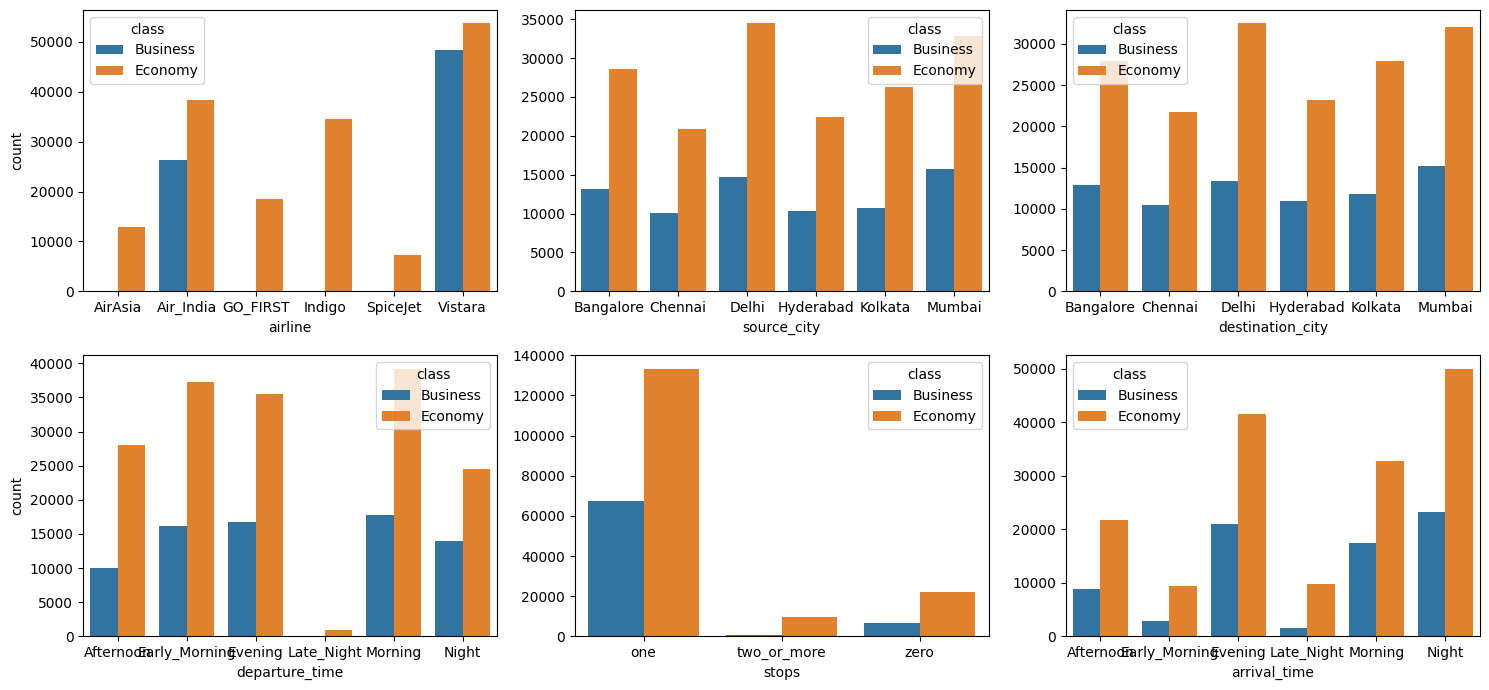

In [14]:
#Análisis bivariado variables categóricas

fig, axis = plt.subplots(2, 3, figsize = (15, 7))

sns.countplot(ax = axis[0, 0], data = df_train, x = "airline", hue = "class")
sns.countplot(ax = axis[0, 1], data = df_train, x = "source_city", hue = "class").set(ylabel = None)
sns.countplot(ax = axis[0, 2], data = df_train, x = "destination_city", hue = "class").set(ylabel = None)
sns.countplot(ax = axis[1, 0], data = df_train, x = "departure_time", hue = "class")
sns.countplot(ax = axis[1, 1], data = df_train, x = "stops", hue = "class").set(ylabel = None)
sns.countplot(ax = axis[1, 2], data = df_train, x = "arrival_time", hue = "class").set(ylabel = None)

plt.tight_layout()
#fig.delaxes(axis[1, 2])

plt.show()

PREPARAMOS DATOS PARA REALIZAR EL MODELO

In [15]:
inputs_dataset = df[inputs_cols].copy()
targets_set    = df[targets_col].copy()

In [16]:
numeric_cols = inputs_dataset.select_dtypes(include=np.number).columns.tolist()
categorical_cols = inputs_dataset.select_dtypes(include='category').columns.tolist()

In [17]:
# Scaling
scaler = MinMaxScaler()
scaler.fit(inputs_dataset[numeric_cols])
inputs_dataset[numeric_cols] = scaler.transform(inputs_dataset[numeric_cols])

In [18]:
# Encoding
encoder = OneHotEncoder(sparse_output=False,handle_unknown='ignore')
encoder.fit(inputs_dataset[categorical_cols])
encoder_cols = encoder.get_feature_names_out(categorical_cols)
inputs_dataset[encoder_cols]=encoder.transform(inputs_dataset[categorical_cols])

In [19]:
X = pd.concat([inputs_dataset[numeric_cols], inputs_dataset[encoder_cols]],axis=1)
y = targets_set

In [20]:
# modeling
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=.20,random_state=42)

In [21]:
lr = LinearRegression()
lr.fit(X_train,y_train)

LinearRegression()

In [22]:
pred = lr.predict(X_test)
pred

array([ 3430.125 , 55152.1875, 10415.125 , ...,  4960.125 , -1633.375 ,
       57505.4375])

In [23]:
lr_score= r2_score(y_test,pred)
lr_score

0.9113048463585258

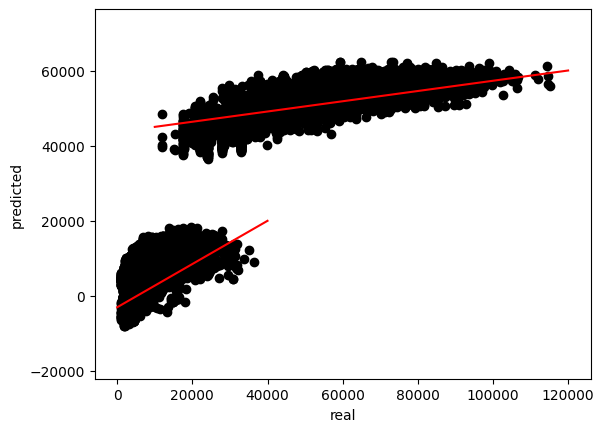

In [24]:
plt.scatter(x= y_test, y= pred, c= 'k')
plt.plot([0,40000],[-3000,20000], c= 'r')
plt.plot([10000,120000],[45000,60000], c= 'r')
plt.axis('equal')
plt.xlabel('real')
plt.ylabel('predicted')
plt.show()

La separación en dos secciones refiere a las dos clases que existen, business y economy.

***** No usar KNN  *****

In [25]:
dtr = DecisionTreeRegressor()
dtr.fit(X_train,y_train)

DecisionTreeRegressor()

In [ ]:
pred_dtr = dtr.predict(X_test)
pred_dtr

array([ 7366., 64831.,  6195., ...,  6314.,  4558., 70049.])

In [27]:
dtr_score= r2_score(y_test,pred_dtr)
dtr_score

0.9757078239022434

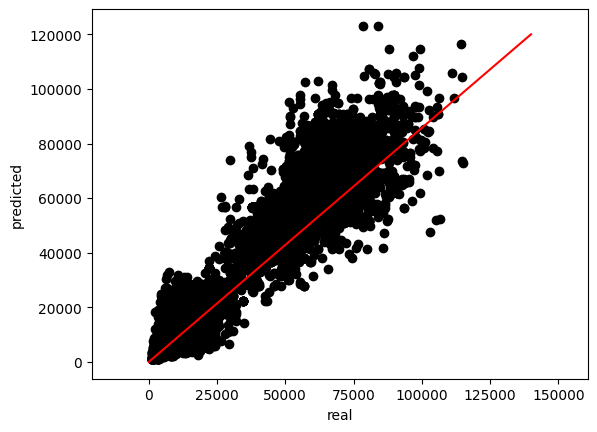

In [28]:
plt.scatter(x= y_test, y= pred_dtr, c= 'k')
plt.plot([0,140000],[0,120000], c= 'r')
plt.axis('equal')
plt.xlabel('real')
plt.ylabel('predicted')
plt.show()

In [29]:
rf = RandomForestRegressor()
rf.fit(X_train,y_train)

RandomForestRegressor()

In [30]:
pred_rf = rf.predict(X_test)
pred_rf

array([ 7374.92, 67288.28,  6195.  , ...,  6471.43,  4146.84, 71339.96])

In [31]:
rf_score= r2_score(y_test,pred_rf)
rf_score

0.984917930646993

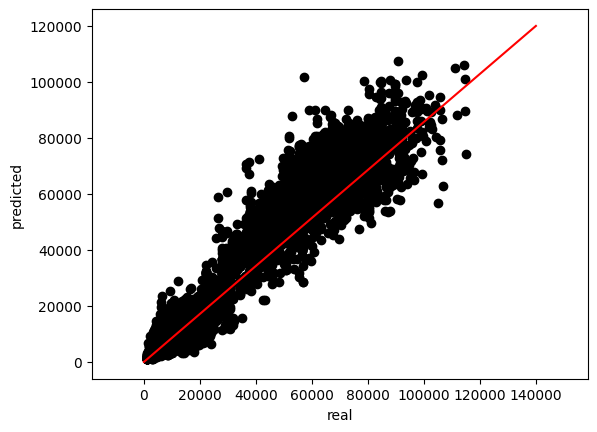

In [32]:
plt.scatter(x= y_test, y= pred_rf, c= 'k')
plt.plot([0,140000],[0,120000], c= 'r')
plt.axis('equal')
plt.xlabel('real')
plt.ylabel('predicted')
plt.show()